In [1]:
# Download GloVe embeddings
!  gdown --id 1DKTVDj3U3dT93EtjrhPNS5kA6mF2t0D0
# Download dataset
!  gdown --id 1R7bnlwW1xUHR5_L6K1ejhYKJlOQoYFSG

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to C:\Users\hager
[nltk_data]     nasser\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\hager
[nltk_data]     nasser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
cols = ['ID(original)', 'ID' , 'Q' , 'A']
data = pd.read_csv('COQB-19_crowdsourced_06202020.csv', sep=',',
                   names=cols, header=None, encoding='latin-1',skiprows=1)
data = data.dropna()
Questions = data['Q']
ID= data['ID'].tolist()
corpus = Questions.tolist()
Answers =data['A'].tolist()

In [4]:
lemmatizer = WordNetLemmatizer()
def stemSentence(sentence):
    token_words= word_tokenize(sentence)
    lematized_tokens = [lemmatizer.lemmatize(w) for w in token_words]
    return "  ".join(lematized_tokens)

In [5]:
stemmed_corpus = []
for i in range(len(corpus)):
  stemmed_corpus.append((i,stemSentence(corpus[i])))

In [6]:
def load_glove_model(glove_file):
    model = {}
    f = open(glove_file + ".txt", 'r', encoding='utf-8')
    for line in f:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array([float(val) for val in split_line[1:]])
        model[word] = embedding
    return model

In [7]:
glove = load_glove_model("glove.6B.50d")
glove_dim = 50

In [8]:
def encode_sentence_as_vector(sentence, model):
  sentence_tokens = sentence.split()
  sentence_array = np.zeros(shape=(len(sentence_tokens), glove_dim))
  for i,w in enumerate(sentence_tokens):
    if w in model:
      sentence_array[i,:] = model[w]
  sentence_vec = np.mean(sentence_array, axis=0)
  return sentence_vec.reshape((1,-1))

In [9]:
Q = np.zeros((len(stemmed_corpus),glove_dim), dtype=np.float64)
for i in range(len(stemmed_corpus)):
  Q[i,:] = encode_sentence_as_vector(stemmed_corpus[i][1], glove)

In [10]:
def answer_question(question, corpus_X):
  lematized_question = stemSentence(question)
  question_x = encode_sentence_as_vector(lematized_question, glove)
  sim_scores = cosine_similarity(question_x,  corpus_X).ravel()
  top_idx = np.argmax(sim_scores)
  return top_idx, sim_scores[top_idx], sim_scores


In [11]:
test_question = 'What are the different risk categories and what is their recovery timeline?'
answer_idx, answer_score,_ = answer_question(test_question, Q)
print('Similarity score = ', answer_score)
print('Most similiar question: ', corpus[stemmed_corpus[answer_idx][0]])
print('suggested answer: ', Answers[stemmed_corpus[answer_idx][0]])

Similarity score =  0.9999999999999998
Most similiar question:  What are the different risk categories and what is their recovery timeline?
suggested answer:  While all ages can be infected by the virus, those with an elevated risk of exposure are people from places where ongoing community spread of the COVID-19-causing virus is occuring, healthcare workers caring for COVID-19 patients, close contacts of persons with COVID-19, and travelers returning from affected international locations where community spread is occurring. Older people and people of all ages with severe underlying health conditions like heart disease, lung disease, and diabetes seem to be at higher risk of developing serious COVID-19 illness.


In [12]:
def compute_precision_recall_at_threshold(corpus, ids, corpus_X, threshold):
  precision_list = []
  recall_list = []
  for i,test_doc in enumerate(corpus):
    if i%20 != 0:
      continue
    _,_,  scores = answer_question(test_doc, corpus_X)
    preds = scores >= threshold
    labels = np.array([a_id==ids[i] for a_id in ids])
    precision_list.append(precision_score(labels, preds))
    recall_list.append(recall_score(labels, preds))
  return np.mean(precision_list),  np.mean(recall_list)

In [13]:
probability_thresholds = np.linspace(0,1, num=50)
prec_list =[]
rec_list =[]
for threshold in probability_thresholds:
  cur_prec, cur_rec = compute_precision_recall_at_threshold(corpus, ID,  Q, threshold)
  prec_list.append(cur_prec)
  rec_list.append(cur_rec)

C:\Users\hager nasser\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hager nasser\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hager nasser\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\h

Text(0, 0.5, 'precision')

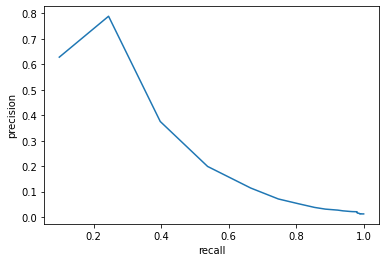

In [14]:
plt.plot(rec_list,  prec_list)
plt.xlabel('recall')
plt.ylabel('precision')

## compute recall at 5.

In [15]:
def compute_prec_recall_at_k(corpus, ids, corpus_X, k=5):
  prec_at_k_list = []
  recall_at_k_list = []
  for i,test_doc in enumerate(corpus):
    if i%20 != 0:
    # this is done only to speed calculations a bit. we compute metrics based
    # on 5% of data.
      continue
    _,_,  scores = answer_question(test_doc, corpus_X)
    top_k_idx = np.argsort(scores)[::-1][:k]
    top_k_labels = [ids[idx] for idx in top_k_idx]
    num_true_labels = np.sum([a_id==ids[i] for a_id in ids])
    num_true_in_top_k = np.sum([a_id==ids[i] for a_id in top_k_labels])
    cur_prec_at_k = num_true_in_top_k/k
    cur_recall_at_k = num_true_in_top_k / num_true_labels
    recall_at_k_list.append(cur_recall_at_k)
    prec_at_k_list.append(cur_prec_at_k)
  return np.mean(prec_at_k_list), np.mean(recall_at_k_list)

In [16]:
print("Prec, Recall at 1 : ",  compute_prec_recall_at_k(corpus, ID,Q, 1))

Prec, Recall at 1 :  (0.9745762711864406, 0.13806606636833285)


In [17]:
print("Prec, Recall at 5 : ",  compute_prec_recall_at_k(corpus, ID,Q, 5))

Prec, Recall at 5 :  (0.5796610169491527, 0.24048878486551648)


In [18]:
print("Prec,Recall at 10 : ",  compute_prec_recall_at_k(corpus, ID,Q, 10))

Prec,Recall at 10 :  (0.4355932203389831, 0.29707389960576663)


In [19]:
from sklearn.metrics import auc
print(f'AUC : {round(auc(rec_list, prec_list),3)}')

AUC : 0.27


In [20]:
f = (2*np.mean(rec_list)*np.mean(prec_list))/(np.mean(rec_list)+np.mean(prec_list))
f

0.11114930476078992